# Checking the Velocity Distribution
## particles coordinates obtained from imageJ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import pandas as pd
import os
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sts

In [2]:
folderPath = r'g:\My Drive\workAppState\prj_shocks\expData\data20230530velDistribTest_ImageJ_Connor'

In [3]:
inputsPath = folderPath + r'\inputs'
infilename = r'\360v_1mA_9sccm_91mtorr'

In [4]:
colnames=['x','y','frame']
indf = pd.read_csv(inputsPath + infilename  + r'.csv', usecols=[3,4,8],names=colnames, skiprows=1)


In [5]:
indf.head()

,x,y,frame
0,345.78586,13.41291,1
1,306.32614,14.01396,1
2,332.94084,13.89708,1
3,319.62251,14.91738,1
4,371.09624,14.78872,1


In [6]:
tracked_csv_dir = folderPath + r'\outputs' + r'\tracked' 
tracked_csv_filepath = tracked_csv_dir + infilename + r'_tracked.csv'
if not os.path.exists(tracked_csv_dir):
    os.makedirs(tracked_csv_dir)
    t_large = tp.link(indf,3,memory=1)
    t_large.to_csv(tracked_csv_filepath)    
else:
    t_large = pd.read_csv(tracked_csv_filepath)
t_large


,Unnamed: 0,x,y,frame,particle
0,0,345.78586,13.41291,1,0
1,1299,563.45040,319.49206,1,1
2,1298,513.90593,319.84384,1,2
3,1297,284.83552,319.66066,1,3
4,1296,206.13283,319.97588,1,4
...,...,...,...,...,...
1872186,1870898,210.52854,191.02396,968,1920
1872187,1870897,612.83741,188.58557,968,1541
1872188,1870896,494.81270,189.19780,968,1895
1872189,1870864,114.40066,184.15846,968,1864


In [7]:
#function get_velocities(df, step) calculates velocites of particles
# with a given step step.
def get_velocities(df, step):
#initialize empy arrays to store data:
    arr_particle = np.array([])
    arr_x = np.array([])
    arr_y = np.array([])
    arr_vx = np.array([])
    arr_vy = np.array([])
    arr_frame = np.array([])
    # get an array containing all frame numbers in the input dataframe:
    frames_listing = np.unique(np.array(df['frame']))
    #cycle throught all those frames:
    for iFrame in range(step, len(frames_listing)):
        #get current frame:
        cur_frame = frames_listing[iFrame]
        #select a dataframe containing data ONLY for that frame:
        df_front_frame = df[(df['frame'] == cur_frame)]
        print(iFrame)
        #cycle throught all particles in the frame and find their velocities as
        # position of the particle in that frame minus position of the same particles
        # step frames ago:
        for i in range(0, len(df_front_frame)):
            #take i-th particle in a frame
            cur_p = df_front_frame['particle'].iloc[i]
            cur_x = df_front_frame['x'].iloc[i]
            cur_y = df_front_frame['y'].iloc[i]
            #find a row with the same particle in a frame step frames ago:
            prev_frame_cur_row = df[((df['frame'] == cur_frame - step) & (df['particle'] == cur_p))]
            #if that particle excisted back then, we will get exactly ONE row:
            if (len(prev_frame_cur_row) == 1):
                #if this row exists, we can take position of that particle in that, previous, frame:
                prev_x = prev_frame_cur_row['x'].iloc[0]
                prev_y = prev_frame_cur_row['y'].iloc[0]
                # so we can calculate velocities:
                cur_vx = cur_x - prev_x
                cur_vy = cur_y - prev_y
                cur_particle = df_front_frame['particle'].iloc[i]
                #and append all parameters of that particle to our data arrays
                arr_vx = np.append(arr_vx, cur_vx)
                arr_vy = np.append(arr_vy, cur_vy)
                arr_particle = np.append(arr_particle, cur_particle)
                arr_x = np.append(arr_x, cur_x)
                arr_y = np.append(arr_y, cur_y)
                arr_frame = np.append(arr_frame, cur_frame)
    #save output as a dataframe containing all the info we need:
    data = {'frame':arr_frame, 'particle':arr_particle, 'x': arr_x, 'y': arr_y, 'vx': arr_vx, 'vy':arr_vy}
    ret_df = pd.DataFrame(data)
                
    return ret_df

In [8]:
# function get_velocities_fast(df, step) does the same thing as
# get_velocities(df, step), but very fast (by avoiding cycles and append())

In [9]:
def get_velocities_fast(df, step):
    df_sorted = df.sort_values(by = ['particle', 'frame'])
    grouped = df_sorted.groupby('particle')
    df_sorted['vx'] = grouped['x'].diff(periods = step)
    df_sorted['vy'] = grouped['y'].diff(periods = step)
    df_sorted = df_sorted.dropna()
    df_sorted = df_sorted.sort_values(by = ['frame', 'particle'])    
    return df_sorted

## Getting the Temperature Profiles

#### constants:

In [11]:
step = 1 # number of frames between the frames for calculating velocities
dust_mass = 4.0 / 3.0 * np.pi * (7.14E-6 / 2.0)**3 * 1510.0 #mass of the dust particles
N_points = 15 # number of points in the temperature profile
rate_for_vel = 99.0 / step # frequency for calculating particle speeds
mm_per_px = 1.0/40.3 # camera resolution
N_bins = 100
left_bins_border = -3.0
right_bins_border = 3.0

#### first, get velocities. May take some time:
#### Velocities obtained with step = 1:

In [12]:
vel_csv_dir = folderPath + r'\outputs\csvData\velocities_step01'
vel_csv_csv_filepath = vel_csv_dir + infilename + r'_velocities_step01.csv'
if not os.path.exists(vel_csv_dir):
    os.makedirs(vel_csv_dir)
    df_vel_step01 = get_velocities(t_large, step)
    df_vel_step01.to_csv(vel_csv_csv_filepath)    
else:
    df_vel_step01 = pd.read_csv(vel_csv_csv_filepath)
df_vel_step01.head()

,Unnamed: 0,frame,particle,x,y,vx,vy
0,0,2.0,9.0,250.48543,318.43861,0.01522,0.17691
1,1,2.0,12.0,173.12657,318.39599,-0.02031,0.06335
2,2,2.0,11.0,390.37302,317.69753,-0.28955,0.32418
3,3,2.0,27.0,500.84187,316.95665,0.07655,0.05680
4,4,2.0,7.0,437.83949,318.62216,-0.12883,0.07270


## Comparting FWHM Method, Direct Method and Fitting method

#### subtracting global cloud drift:

In [15]:
meanVx = np.mean(df_vel_step01['vx'])
meanVy = np.mean(df_vel_step01['vy'])
arr_vx_noDrift = np.array(df_vel_step01['vx']) - meanVx
arr_vy_noDrift = np.array(df_vel_step01['vy']) - meanVy

##### calculating histogram

In [19]:
my_bins = np.linspace(left_bins_border, right_bins_border, N_bins)
total_vx_samples = len(arr_vx_noDrift)
counts_x, bins_x = np.histogram(arr_vx_noDrift, bins = my_bins)
arr_bins_x_centers = 0.5 * (bins_x[1:] + bins_x[:-1]) # array of the bin centers
bin_wid = np.abs(arr_bins_x_centers[1] - arr_bins_x_centers[0])
arr_vx_freqs = counts_x / total_vx_samples / bin_wid # histogram frequencies

(-1.0, 1.0)

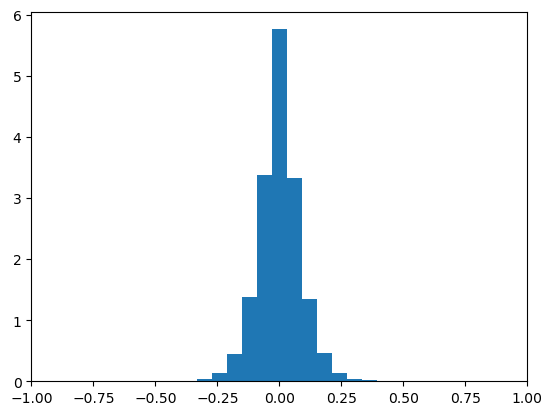

In [31]:
#plotting the histogram
fig_hist_x, ax_hist_x = plt.subplots()
ax_hist_x.bar(arr_bins_x_centers, arr_vx_freqs, width = bin_wid)
ax_hist_x.set_xlim([-1, 1])

#### Since the datapoints are sparse, do a cubic splines interpolation:

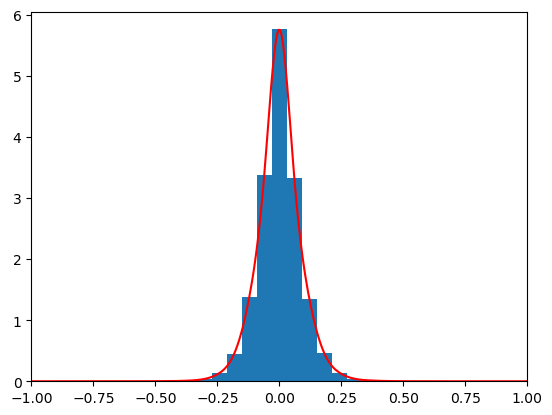

In [32]:
# ten times more dense bins:
arr_bins_dense = np.linspace(np.min(arr_bins_x_centers), np.max(arr_bins_x_centers), num = N_bins * 10)
#interpolating function made of cubic splines:
fx = interp1d(arr_bins_x_centers, arr_vx_freqs, kind = 'cubic')
#interpolate the data:
arr_f_x_interp = fx(arr_bins_dense)
#plot
ax_hist_x.plot(arr_bins_dense, arr_f_x_interp, color = 'red', label = 'cubic spline interpolation')
fig_hist_x

#### FWHM method:

In [33]:
f_vx_halfmax = np.max(arr_f_x_interp) / 2.0 #calculate the halfmaximum of the interpolated data
#find all x-values corresponding to y-valies laying ABOVE the halfmaximum
arr_vx_above_halfmax = arr_bins_dense[(arr_f_x_interp > f_vx_halfmax)]
#minimum of the x-values will be the left boundary
left_bound_vx = np.min(arr_vx_above_halfmax)
# maximum is the right boundary
right_bound_vx = np.max(arr_vx_above_halfmax)
#FWHM is rgith boundary minus left boundary
FWHM_vx = right_bound_vx - left_bound_vx
FWHM_vx

0.13674280340946998

In [34]:
sigma_vx_fromFWHM = FWHM_vx / 2.0 / np.sqrt(2 * np.log(2))
sigma_vx_fromFWHM

0.05806932198408086

In [ ]:
ax_hist_x.plot(arr_bins_dense, 1 / np.sqrt(2 * np.pi) / sigma_vx * np.exp(-(mu_vx - arr_bins_dense)**2 / 2 / sigma_vx**2), color = 'black',
        label = r'direct method Gaussian')
legend = ax_hist_x.legend()

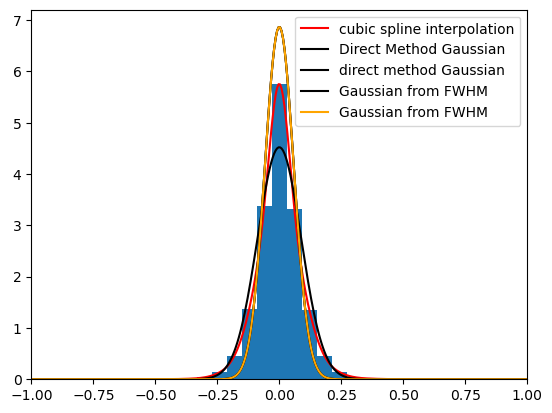

In [41]:
ax_hist_x.plot(arr_bins_dense, 1 / np.sqrt(2 * np.pi) / sigma_vx_fromFWHM * np.exp(-(mu_vx - arr_bins_dense)**2 / 2 / sigma_vx_fromFWHM**2), color = 'orange',
        label = r'Gaussian from FWHM')
legend = ax_hist_x.legend()
fig_hist_x

### Velocities obtained with step = 1:

#### constants:

In [ ]:
step = 1 # number of frames between the frames for calculating velocities
dust_mass = 4.0 / 3.0 * np.pi * (7.14E-6 / 2.0)**3 * 1510.0 #mass of the dust particles
N_points = 15 # number of points in the temperature profile
rate_for_vel = 99.0 / step # frequency for calculating particle speeds
mm_per_px = 1.0/121.8 # camera resolution
N_bins = 300
left_bins_border = -3.0
right_bins_border = 3.0

In [ ]:
vel_csv_dir = folderPath + r'\outputs\csvData\velocities_step01'
vel_csv_csv_filepath = vel_csv_dir + infilename + r'_velocities_step01.csv'
if not os.path.exists(vel_csv_dir):
    os.makedirs(vel_csv_dir)
    df_vel_step01 = get_velocities(t_large, step)
    df_vel_step01.to_csv(vel_csv_csv_filepath)    
else:
    df_vel_step01 = pd.read_csv(vel_csv_csv_filepath)
df_vel_step01.head()

In [ ]:
meanVx = np.mean(df_vel_step01['vx'])
meanVy = np.mean(df_vel_step01['vy'])
arr_vx_noDrift = np.array(df_vel_step01['vx']) - meanVx
arr_vx_noDrift = arr_vx_noDrift[(arr_vx_noDrift > left_bins_border) & (arr_vx_noDrift < right_bins_border)]
arr_vy_noDrift = np.array(df_vel_step01['vy']) - meanVy
sigma_vx = np.std(arr_vx_noDrift)
mu_vx = np.mean(arr_vx_noDrift)
my_bins = np.linspace(left_bins_border, right_bins_border, N_bins)
total_vx_hist_counts = len(arr_vx_noDrift[(arr_vx_noDrift > left_bins_border) & (arr_vx_noDrift < right_bins_border)])
total_vx_hist_counts
#calculating histogram
counts_x, bins_x = np.histogram(arr_vx_noDrift, bins = my_bins)
arr_bins_x_centers = 0.5 * (bins_x[1:] + bins_x[:-1]) # array of the bin centers
bin_wid = np.abs(arr_bins_x_centers[1] - arr_bins_x_centers[0])
arr_vx_freqs = counts_x / float(len(arr_vx_noDrift)) / bin_wid # histogram frequencies
#plotting the histogram
fig_hist_x, ax_hist_x = plt.subplots()
ax_hist_x.bar(arr_bins_x_centers, arr_vx_freqs, width = (arr_bins_x_centers[1] - arr_bins_x_centers[0]))
# ten times more dense bins:
arr_bins_dense = np.linspace(np.min(arr_bins_x_centers), np.max(arr_bins_x_centers), num = N_bins * 10)
#interpolating function made of cubic splines:
fx = interp1d(arr_bins_x_centers, arr_vx_freqs, kind = 'cubic')
#interpolate the data:
arr_f_x_interp = fx(arr_bins_dense)
#plot
ax_hist_x.plot(arr_bins_dense, arr_f_x_interp, color = 'red')
ax_hist_x.plot(arr_bins_dense, 1 / np.sqrt(2 * np.pi) / sigma_vx * np.exp(-(mu_vx - arr_bins_dense)**2 / 2 / sigma_vx**2), color = 'black',
        label = r'$f_k \ = \frac{1}{\sigma_{vx} \sqrt{2 \pi}} e^{-(x_f - \mu_f)^2 / {2 \sigma_{vx}^2}}$ ')
legend = ax_hist_x.legend()

ax_hist_x.plot(arr_bins_dense, 1 / np.sqrt(2 * np.pi) / 0.07498 * np.exp(-(0 - arr_bins_dense)**2 / 2 / 0.07498**2), color = 'yellow',
        label = r'$f_k \ = \frac{1}{\sigma_{vx} \sqrt{2 \pi}} e^{-(x_f - \mu_f)^2 / {2 \sigma_{vx}^2}}$ ')
ax_hist_x.set_xlim([-1, 1])

In [ ]:
bin_wid

In [ ]:
sigma_vx

In [ ]:
f_vx_halfmax = np.max(arr_f_x_interp) / 2.0 #calculate the halfmaximum of the interpolated data
#find all x-values corresponding to y-valies laying ABOVE the halfmaximum
arr_vx_above_halfmax = arr_bins_dense[(arr_f_x_interp > f_vx_halfmax)]
#minimum of the x-values will be the left boundary
left_bound_vx = np.min(arr_vx_above_halfmax)
# maximum is the right boundary
right_bound_vx = np.max(arr_vx_above_halfmax)
#FWHM is rgith boundary minus left boundary
FWHM_vx = right_bound_vx - left_bound_vx
FWHM_vx

In [ ]:
0.07498 * 2.35

In [ ]:
#quick check, for Gaussian distribution, FWHM should coincide with
sigma_vx = np.std(arr_vx_noDrift)
mu_vx = np.mean(arr_vx_noDrift)
sigma_vx * 2 * np.sqrt(2 * np.log(2))

In [ ]:
np.min(np.abs(arr_vx_noDrift))

In [ ]:
np.max(arr_vx_noDrift)

In [ ]:
np.min(arr_vx_noDrift)

In [ ]:
t_large_t = tp.link(indf, 10.0 ,memory = 0)

In [ ]:
len(t_large_t)

In [ ]:
df_vel_t = get_velocities_fast(t_large_t, 1)

In [ ]:
arr_vx_t = np.array(df_vel_t['vx']) - np.mean(np.array(df_vel_t['vx']))

In [ ]:
np.max(arr_vx_t)

In [ ]:
np.max(np.array(df_vel_t['vx']))

In [ ]:
np.mean(np.array(df_vel_t['vx']))

In [ ]:
np.min(arr_vx_t)

In [ ]:
meanVx = np.mean(df_vel_t['vx'])
meanVy = np.mean(df_vel_t['vy'])
arr_vx_noDrift = np.array(df_vel_t['vx']) - meanVx
arr_vx_noDrift = arr_vx_noDrift[(arr_vx_noDrift > left_bins_border) & (arr_vx_noDrift < right_bins_border)]
arr_vy_noDrift = np.array(df_vel_step01['vy']) - meanVy
my_bins = np.linspace(left_bins_border, right_bins_border, N_bins)
total_vx_hist_counts = len(arr_vx_noDrift[(arr_vx_noDrift > left_bins_border) & (arr_vx_noDrift < right_bins_border)])
total_vx_hist_counts
#calculating histogram
counts_x, bins_x = np.histogram(arr_vx_noDrift, bins = my_bins)
arr_bins_x_centers = 0.5 * (bins_x[1:] + bins_x[:-1]) # array of the bin centers
arr_vx_freqs = counts_x / len(arr_vx_noDrift) # histogram frequencies
#plotting the histogram
fig_hist_x, ax_hist_x = plt.subplots()
ax_hist_x.bar(arr_bins_x_centers, arr_vx_freqs, width = (arr_bins_x_centers[1] - arr_bins_x_centers[0]))
# ten times more dense bins:
arr_bins_dense = np.linspace(np.min(arr_bins_x_centers), np.max(arr_bins_x_centers), num = N_bins * 10)
#interpolating function made of cubic splines:
fx = interp1d(arr_bins_x_centers, arr_vx_freqs, kind = 'cubic')
#interpolate the data:
arr_f_x_interp = fx(arr_bins_dense)
#plot
ax_hist_x.plot(arr_bins_dense, arr_f_x_interp, color = 'red')
ax_hist_x.plot(arr_bins_dense, 1 / np.sqrt(2 * np.pi) / sigma_vx * np.exp(-(mu_vx - arr_bins_dense)**2 / 2 / sigma_vx**2), color = 'black',
        label = r'$f_k \ = \frac{1}{\sigma_{vx} \sqrt{2 \pi}} e^{-(x_f - \mu_f)^2 / {2 \sigma_{vx}^2}}$ ')
legend = ax_hist_x.legend()

In [ ]:


def my_gauss(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(mu - x)**2 / 2 / sigma**2)


params, params_covariance = curve_fit(my_gauss, arr_bins_x_centers, arr_vx_freqs,  bounds=(0, [0.000001, 10.]))

In [ ]:
params

In [ ]:
params_covariance

In [ ]:
np.sum(arr_vx_freqs)*bin_wid

In [ ]:
np.sum(arr_vx_freqs)